In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from spreg import OLS
from libpysal.weights import Kernel
from esda.moran import Moran

from scipy import stats
from sklearn.linear_model import LinearRegression

In [ ]:
loc_gdf=gpd.read_file('data/AQMS_loc.shp')

# Initialise

In [2]:
# Read in all the data

AQMS_df=pd.read_csv('data/hourly.csv')
Rd_gdf=gpd.read_file('data/london_Road.shp')
Gsp_gdf=gpd.read_file('data/LD_GreenSpace.shp')

cond=pd.read_csv('data/cond_hourly.csv')

In [3]:
# reindex loc_gdf and set buffer zones around each site (1km)

loc_gdf=loc_gdf.set_index('siteid')
loc_gdf['buffer_1km']=loc_gdf['geometry'].buffer(1000)

In [4]:
# Get all green spaces
Gsp=Gsp_gdf['geometry'].unary_union

# Get all roads
Rd=Rd_gdf['geometry'].unary_union

In [5]:
# Set buffer zones for every road (50m)
Rd_gdf['buffer_50m']=Rd_gdf['geometry'].buffer(50)
# Get all road buffer zones
Rd_buffer=Rd_gdf['buffer_50m'].unary_union

In [6]:
# Get all near-road green spaces
nRd_Gsp=Gsp.intersection(Rd_buffer)

In [7]:
# Get all near-greenspace roads
nRd_Gsp_buffer=nRd_Gsp.buffer(50)
nGsp_Rd=Rd.intersection(nRd_Gsp_buffer)

In [8]:
# store all buffer zones in a list
AQMS_shp=[]
for site in loc_gdf.index:
    AQMS_shp.append(loc_gdf.loc[site,'buffer_1km'])

In [9]:
# get all roads, green spaces, near-road green spaces and near-gsp roads in buffer zones around every sites
Rd_shp=[]
Gsp_shp=[]
nRd_Gsp_shp=[]
nGsp_Rd_shp=[]
for poly in AQMS_shp:
    Rd_shp.append(poly.intersection(Rd))
    Gsp_shp.append(poly.intersection(Gsp))
    nRd_Gsp_shp.append(poly.intersection(nRd_Gsp))
    nGsp_Rd_shp.append(poly.intersection(nGsp_Rd))
print(len(Rd_shp),len(Gsp_shp),len(nRd_Gsp_shp),len(nGsp_Rd_shp))

21 21 21 21


In [10]:
# append them into the dataframe
loc_gdf['Rd']=Rd_shp
loc_gdf['Gsp']=Gsp_shp
loc_gdf['nRd_Gsp']=nRd_Gsp_shp
loc_gdf['nGsp_Rd']=nGsp_Rd_shp

# and set their data types to geometry
loc_gdf=loc_gdf.set_geometry('Rd').set_geometry('Gsp').set_geometry('nRd_Gsp').set_geometry('nGsp_Rd')

In [ ]:
# london boundary read in
london=gpd.read_file('data/london_boundary.shp')

In [ ]:
# visualise all the sites on the map
fig,ax=plt.subplots(1,figsize=(15,13))

london.plot(color='lightgrey',ax=ax)
loc_gdf['buffer_1km'].plot(color='silver',ax=ax)
loc_gdf['Gsp'].plot(label='Green space',color='limegreen',ax=ax)
loc_gdf['nRd_Gsp'].plot(label='Near_road green space',color='darkgreen',ax=ax)
loc_gdf['Rd'].plot(color='black',label='Road',linewidth=0.1,ax=ax)
loc_gdf['geometry'].plot(markersize=5,marker='^',color='blue',label='Air quality monitoring site',ax=ax)

ax.axis('off')

legend=ax.legend(loc='best',shadow=True,fontsize=15)

#plt.savefig('sample1.png',facecolor='black',dpi=500)
plt.show()

There are some buffers that seem to be very close to each other.

In [11]:
# add a column that specifies the shortest distance of a site to its nearest neighbour
loc_gdf['min_dis']=pd.Series(dtype='float64')
for index, row in loc_gdf.iterrows():
    dis=[]
    for i, v in loc_gdf['geometry'].iteritems():
        dis.append(row['geometry'].distance(v))
    dis.remove(0)
    loc_gdf.loc[index,'min_dis']=min(dis)

In [12]:
# list sites that are close to each other (within 1.5km)
loc_gdf[loc_gdf['min_dis']<=1500]

,sitename,geometry,buffer_1km,Rd,Gsp,nRd_Gsp,nGsp_Rd,min_dis
siteid,,,,,,,,
BL0,Camden - Bloomsbury,POINT (530120.048 182038.807),"POLYGON ((531120.048 182038.807, 531115.233 18...",MULTILINESTRING Z ((530175.051 181041.510 0.00...,"MULTIPOLYGON Z (((530885.507 181396.082 0.000,...","MULTIPOLYGON Z (((530885.507 181396.082 0.000,...",MULTILINESTRING Z ((530466.022 181148.842 0.00...,664.503439
CD9,Camden - Euston Road,POINT (529900.870 182666.124),"POLYGON ((530900.870 182666.124, 530896.055 18...",MULTILINESTRING Z ((529650.665 181699.144 0.00...,"MULTIPOLYGON Z (((530446.501 181828.697 0.000,...","MULTIPOLYGON Z (((530446.501 181828.697 0.000,...",MULTILINESTRING Z ((530105.671 181827.567 0.00...,664.503439
GR4,Greenwich - Eltham,POINT (543978.694 174655.234),"POLYGON ((544978.694 174655.234, 544973.878 17...",MULTILINESTRING Z ((544415.352 173756.882 0.00...,"MULTIPOLYGON Z (((544534.534 173823.964 0.000,...","MULTIPOLYGON Z (((544534.534 173823.964 0.000,...",MULTILINESTRING Z ((544415.352 173756.882 0.00...,1111.316933
GB0,Greenwich - Falconwood FDMS,POINT (544997.933 175098.152),"POLYGON ((545997.933 175098.152, 545993.118 17...",MULTILINESTRING Z ((544952.089 174100.404 0.00...,"MULTIPOLYGON Z (((545373.964 174171.892 0.000,...","MULTIPOLYGON Z (((545223.244 174124.937 0.000,...",MULTILINESTRING Z ((545144.788 174118.625 0.00...,1111.316933


In [13]:
# check their readings' descriptive statistics
AQMS_df[AQMS_df['Site'].isin(['BL0','CD9','GR4','GB0'])].groupby('Site').describe()

Value                                                    
       count       mean        std  min  25%   50%     75%   max
Site                                                            
BL0   8760.0  10.869803   9.945936  0.1  4.9   7.9  12.425  92.4
CD9   8760.0  13.753847  10.294305  0.1  7.4  11.1  16.300  83.9
GB0   8760.0  12.177603   8.968893  0.1  6.8   9.5  14.000  79.8
GR4   8760.0  11.002225   9.712762  0.1  5.4   8.3  12.300  97.6

In [14]:
stats.ttest_rel(AQMS_df[AQMS_df['Site']=='BL0'].Value.values,AQMS_df[AQMS_df['Site']=='CD9'].Value.values)

Ttest_relResult(statistic=-64.50762336133032, pvalue=0.0)

In [15]:
stats.ttest_rel(AQMS_df[AQMS_df['Site']=='GR4'].Value.values,AQMS_df[AQMS_df['Site']=='GB0'].Value.values)

Ttest_relResult(statistic=-23.998842951363066, pvalue=2.5707190294625883e-123)

Both indicate that we should reject H0, meaning the two datasets are statistically significantly different.

In [ ]:
# revmove them from the list
loc_gdf.drop(['BL0','GR4'],inplace=True)

In [117]:
# get the area of each buffer zone
loc_gdf['buffer_area']=loc_gdf['buffer_1km'].area

In [121]:
loc_gdf['Rd_len']=loc_gdf['Rd'].length

In [122]:
# get percentages of green space and near-road green space areas 
loc_gdf['Gsp_area']=loc_gdf['Gsp'].area
loc_gdf['pct_nRd_Gsp']=loc_gdf['nRd_Gsp'].area/loc_gdf['Gsp_area']*100

In [19]:
# near-road green space area per road length
loc_gdf['nRd_Gsp_per_Rd_len']=loc_gdf['nRd_Gsp'].area/loc_gdf['Rd_len']

In [20]:
# percentage of near-green-space road
loc_gdf['pct_nGsp_Rd']=loc_gdf['nGsp_Rd'].length/loc_gdf['Rd_len']*100

In [153]:
# merge PM reading and site geogemetry data
df=pd.merge(AQMS_df,loc_gdf,left_on='Site',right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183960 entries, 0 to 183959
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   Site                183960 non-null  object  
 1   Value               183960 non-null  float64 
 2   DateTime            183960 non-null  object  
 3   sitename            183960 non-null  object  
 4   geometry            183960 non-null  geometry
 5   buffer_1km          183960 non-null  geometry
 6   Rd                  183960 non-null  geometry
 7   Gsp                 183960 non-null  geometry
 8   nRd_Gsp             183960 non-null  geometry
 9   nGsp_Rd             183960 non-null  geometry
 10  min_dis             183960 non-null  float64 
 11  buffer_area         183960 non-null  float64 
 12  Rd_len              183960 non-null  float64 
 13  Gsp_area            183960 non-null  float64 
 14  pct_nRd_Gsp         183960 non-null  float64 
 15  nRd_Gsp_per_Rd_le

In [154]:
# drop irrelevant columns
df.drop(['sitename','buffer_1km','Rd','Gsp','nRd_Gsp','nGsp_Rd','min_dis','buffer_area'],
        axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183960 entries, 0 to 183959
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   Site                183960 non-null  object  
 1   Value               183960 non-null  float64 
 2   DateTime            183960 non-null  object  
 3   geometry            183960 non-null  geometry
 4   Rd_len              183960 non-null  float64 
 5   Gsp_area            183960 non-null  float64 
 6   pct_nRd_Gsp         183960 non-null  float64 
 7   nRd_Gsp_per_Rd_len  183960 non-null  float64 
 8   pct_nGsp_Rd         183960 non-null  float64 
dtypes: float64(6), geometry(1), object(2)
memory usage: 14.0+ MB


In [155]:
# covert the DateTime column to numpy.datetime variable
df['DateTime']=pd.to_datetime(df['DateTime'])

In [ ]:
# change of moran's I during the year of 2019
sns.set_theme(style='darkgrid')
sns.lineplot(x=df['DateTime'].unique(),y=moran,linewidth=0.13)

In [156]:
# merge with conditional variables
cond['DateTime']=pd.to_datetime(cond['DateTime'])
df=df.merge(cond,on='DateTime')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183960 entries, 0 to 183959
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Site                183960 non-null  object        
 1   Value               183960 non-null  float64       
 2   DateTime            183960 non-null  datetime64[ns]
 3   geometry            183960 non-null  geometry      
 4   Rd_len              183960 non-null  float64       
 5   Gsp_area            183960 non-null  float64       
 6   pct_nRd_Gsp         183960 non-null  float64       
 7   nRd_Gsp_per_Rd_len  183960 non-null  float64       
 8   pct_nGsp_Rd         183960 non-null  float64       
 9   bp_mean             183960 non-null  float64       
 10  tmp_mean            183960 non-null  float64       
 11  rh_mean             183960 non-null  float64       
dtypes: datetime64[ns](1), float64(9), geometry(1), object(1)
memory usage: 18.2+ MB


array([[<AxesSubplot:title={'center':'Value'}>,
        <AxesSubplot:title={'center':'DateTime'}>,
        <AxesSubplot:title={'center':'Rd_len'}>],
       [<AxesSubplot:title={'center':'Gsp_area'}>,
        <AxesSubplot:title={'center':'pct_nRd_Gsp'}>,
        <AxesSubplot:title={'center':'nRd_Gsp_per_Rd_len'}>],
       [<AxesSubplot:title={'center':'pct_nGsp_Rd'}>,
        <AxesSubplot:title={'center':'bp_mean'}>,
        <AxesSubplot:title={'center':'tmp_mean'}>],
       [<AxesSubplot:title={'center':'rh_mean'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

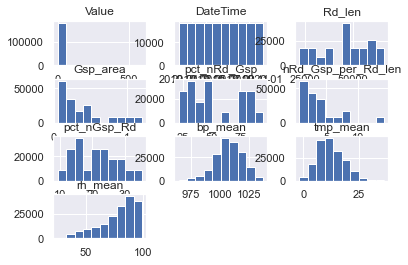

In [135]:
df.hist()

<AxesSubplot:>

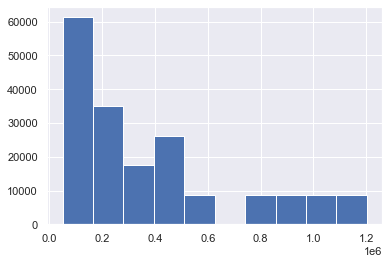

In [136]:
df['Gsp_area'].hist()

<AxesSubplot:>

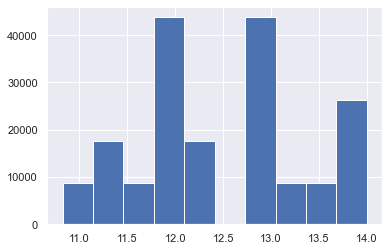

In [157]:
df['log_Gsp_area']=np.log(df['Gsp_area'])
df['log_Gsp_area'].hist()

<AxesSubplot:>

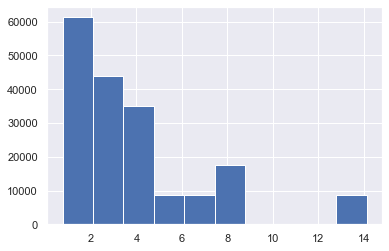

In [141]:
df['nRd_Gsp_per_Rd_len'].hist()

<AxesSubplot:>

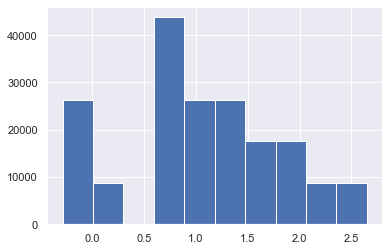

In [158]:
df['log_nRd_Gsp_per_Rd_len']=np.log(df['nRd_Gsp_per_Rd_len'])
df['log_nRd_Gsp_per_Rd_len'].hist()

In [143]:
df[var_names].describe()

,Rd_len,Gsp_area,pct_nRd_Gsp,nRd_Gsp_per_Rd_len,pct_nGsp_Rd
count,183960.000000,1.839600e+05,183960.000000,183960.000000,183960.000000
mean,46008.866273,3.848081e+05,52.591993,3.829805,21.129324
std,12609.033229,3.350841e+05,22.828019,3.125978,6.849604
min,21908.155991,5.025800e+04,21.530661,0.751874,9.316740
25%,36565.805888,1.497242e+05,31.798326,1.944190,16.003498
50%,47512.785492,1.955880e+05,44.514872,2.728806,21.354334
75%,55222.397791,4.220052e+05,76.940177,4.607014,25.024204
max,66247.190928,1.202753e+06,94.958109,14.134284,35.339185


In [159]:
# feature scaling
df['Rd_len']=df['Rd_len']/1000

In [160]:
df.to_csv('temp_data.csv',index=False)

# Temporarily save

In [ ]:
df=pd.read_csv('temp_data.csv')

In [131]:
var_names=loc_gdf.columns[9:].values.tolist()

In [146]:
var_names[1]='log_Gsp_area'
var_names[3]='log_nRd_Gsp_per_Rd_len'
var_names

['Rd_len',
 'log_Gsp_area',
 'pct_nRd_Gsp',
 'log_nRd_Gsp_per_Rd_len',
 'pct_nGsp_Rd']

In [23]:
# kernel weight matrix for the sites
weight=Kernel.from_dataframe(loc_gdf,geom_col='geometry',function='gaussian')

In [ ]:
# moran's Is for PM readings on different days
moran=[]
for date in df['DateTime'].unique():
    mi=Moran(df[df['DateTime']==date].Value.values,weight)
    moran.append(mi.I)
len(moran)

In [132]:
for var in var_names:
    moran_temp=Moran(loc_gdf[var].values,weight)
    print("Global Moran's I for "+var+' '+str(round(moran_temp.I,5)))

Global Moran's I for Rd_len 0.23493
Global Moran's I for Gsp_area 0.15159
Global Moran's I for pct_nRd_Gsp 0.11296
Global Moran's I for nRd_Gsp_per_Rd_len 0.131
Global Moran's I for pct_nGsp_Rd 0.06421


In [147]:
df['week']=df['DateTime'].dt.isocalendar().week

<AxesSubplot:xlabel='hour'>

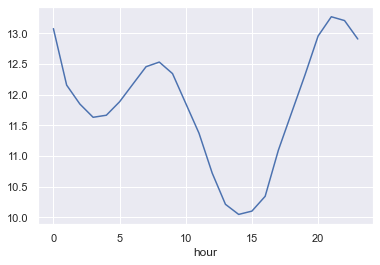

In [148]:
df['hour']=df['DateTime'].dt.hour
df.groupby('hour').mean()['Value'].plot()

<AxesSubplot:xlabel='dayofweek'>

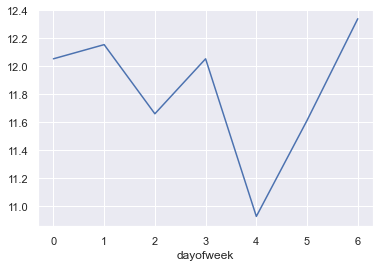

In [149]:
df['dayofweek']=df['DateTime'].dt.dayofweek
df.groupby('dayofweek').mean()['Value'].plot()

<AxesSubplot:xlabel='dayofmonth'>

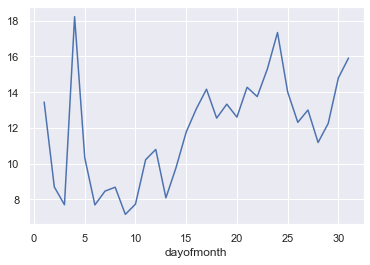

In [150]:
df['dayofmonth']=df['DateTime'].dt.day
df.groupby('dayofmonth').mean()['Value'].plot()

In [42]:
hmean_df=df.groupby(['hour','Site']).mean()
hmean_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 504 entries, (0, 'BL0') to (23, 'TH4')
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Value                   504 non-null    float64
 1   Rd_len                  504 non-null    float64
 2   Gsp_area                504 non-null    float64
 3   pct_nRd_Gsp             504 non-null    float64
 4   nRd_Gsp_per_Rd_len      504 non-null    float64
 5   pct_nGsp_Rd             504 non-null    float64
 6   bp_mean                 504 non-null    float64
 7   tmp_mean                504 non-null    float64
 8   rh_mean                 504 non-null    float64
 9   log_Gsp_area            504 non-null    float64
 10  log_nRd_Gsp_per_Rd_len  504 non-null    float64
 11  week                    504 non-null    Float64
 12  dayofweek               504 non-null    float64
 13  dayofmonth              504 non-null    float64
dtypes: Float64(1), float64(13

In [43]:
hmean_df.drop(['week','dayofweek','dayofmonth'],axis=1,inplace=True)

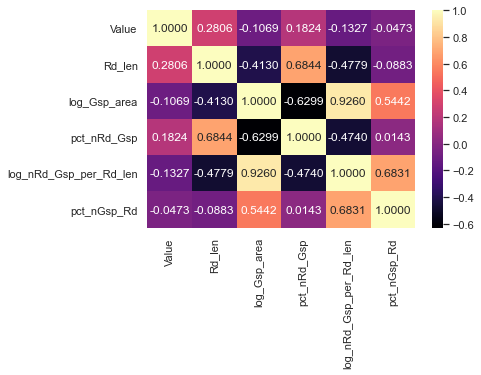

In [46]:
sns.heatmap(hmean_df[['Value']+var_names].corr(method='spearman').round(4),annot=True,fmt='.4f',cmap='magma')
plt.show()

In [68]:
range(12)

range(0, 12)

In [93]:
def get_corr(df,iter_range,method='pearson',indep=var_names,dep='Value'):
    result=[]
    for index in iter_range:
        result.append(df.loc[(index,)].corr(method=method).loc[indep,'Value'])
    result=np.asarray(result)
    return result

In [112]:
def get_reg_info(df,iter_range,features=var_names,target='Value',reg=LinearRegression()):
    result=[]
    for index in iter_range:
        x=df.loc[(index,),features].values
        #x=(x-np.mean(x,axis=0))/np.std(x,axis=0)
        
        y=df.loc[(index,),target].values
        #y=(y-np.mean(y,axis=0))/np.std(y,axis=0)
        
        reg.fit(x,y)
        coef=reg.coef_.tolist()
        coef.append(reg.score(x,y))
        result.append(coef)
    result=pd.DataFrame(result,columns=features+['score'])
    return result

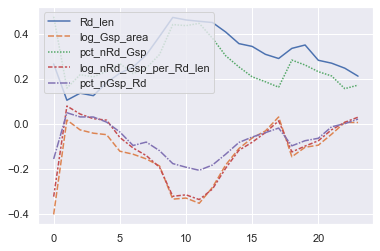

In [71]:
hmean_corr=get_corr(hmean_df,range(24))
sns.lineplot(data=hmean_corr,legend=False)
plt.legend(labels=var_names)
plt.show()

<AxesSubplot:ylabel='score'>

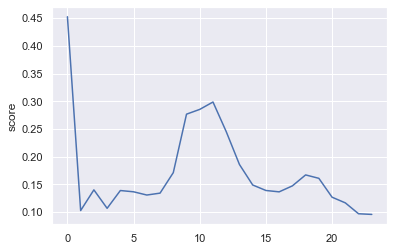

In [113]:
hmean_reg=get_reg_info(hmean_df,range(24))
sns.lineplot(x=range(24),y=hmean_reg['score'])

<AxesSubplot:xlabel='month'>

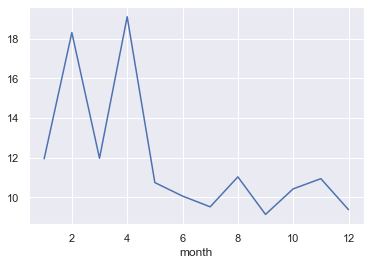

In [151]:
# set up a new column for month information
df['month']=df['DateTime'].dt.month

# plot monthly mean
df.groupby('month').mean()['Value'].plot()

In [152]:
mmean_df=df.groupby(['month','Site']).mean()
mmean_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 252 entries, (1, 'BL0') to (12, 'TH4')
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Value                   252 non-null    float64
 1   Rd_len                  252 non-null    float64
 2   Gsp_area                252 non-null    float64
 3   pct_nRd_Gsp             252 non-null    float64
 4   nRd_Gsp_per_Rd_len      252 non-null    float64
 5   pct_nGsp_Rd             252 non-null    float64
 6   bp_mean                 252 non-null    float64
 7   tmp_mean                252 non-null    float64
 8   rh_mean                 252 non-null    float64
 9   log_Gsp_area            252 non-null    float64
 10  log_nRd_Gsp_per_Rd_len  252 non-null    float64
 11  week                    252 non-null    Float64
 12  hour                    252 non-null    float64
 13  dayofweek               252 non-null    float64
 14  dayofmonth              2

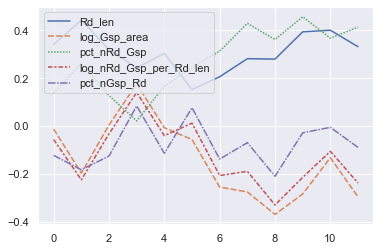

In [76]:
mmean_corr=get_corr(mmean_df,range(1,13))
sns.lineplot(data=mmean_corr,legend=False)
plt.legend(labels=var_names,loc='upper left')
plt.show()

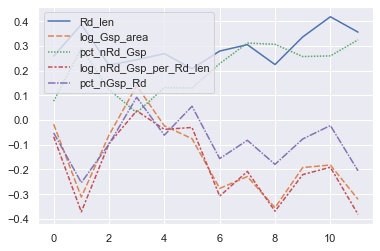

In [78]:
mmean_corr_sp=get_corr(mmean_df,range(1,13),method='spearman')
sns.lineplot(data=mmean_corr_sp,legend=False)
plt.legend(labels=var_names,loc='upper left')
plt.show()

<AxesSubplot:ylabel='score'>

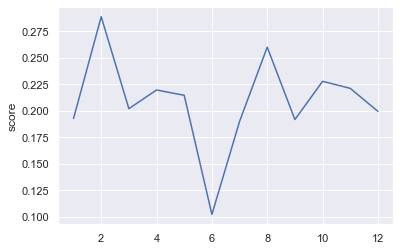

In [114]:
mmean_reg=get_reg_info(mmean_df,range(1,13))
sns.lineplot(x=range(1,13),y=mmean_reg['score'])

In [115]:
mmean_reg

,Rd_len,log_Gsp_area,pct_nRd_Gsp,log_nRd_Gsp_per_Rd_len,pct_nGsp_Rd,score
0,0.000100,-2.028771,-0.035764,2.880863,-0.077744,0.192866
1,0.000309,-9.305301,-0.186668,9.284862,-0.013517,0.288693
2,0.000101,-2.124645,-0.032198,3.265911,-0.105691,0.202068
3,0.000211,-5.878628,-0.132197,6.324078,0.018908,0.219689
4,-0.000083,5.044967,0.125608,-3.254626,-0.178526,0.214672
5,-0.000061,2.305717,0.080547,-1.306051,-0.077987,0.102434
6,-0.000154,5.597912,0.158585,-4.513727,-0.151020,0.190048
7,-0.000124,4.446720,0.145903,-3.197225,-0.146393,0.260027
8,-0.000047,1.646359,0.065879,-1.361233,-0.084705,0.191827
9,0.000036,-0.871871,0.009414,1.125666,-0.026110,0.227828


In [110]:
# identify high period and low period
high=df[df['month'].isin([1,2,3,4])].copy()
low=df[~df['month'].isin([1,2,3,4])].copy()

print('high: '+str(high.shape)+'\nlow: '+str(low.shape))

high: (60480, 19)
low: (123480, 19)


In [ ]:
sns.heatmap(high.groupby('Site').mean()[['Value']+var_names].corr().round(4),
            annot=True,fmt='.4f',cmap='magma')
plt.show()

In [ ]:
y_high=(high.groupby('Site').mean()['Value'].values)
x_high=(high.groupby('Site').mean()[var_names].values)

reg.fit(x_high,y_high)
reg.score(x_high,y_high)

In [ ]:
sns.heatmap(low.groupby('Site').mean()[['Value']+var_names].corr().round(4),
            annot=True,fmt='.4f',cmap='magma')
plt.show()

In [ ]:
y_low=(low.groupby('Site').mean()['Value'].values)
x_low=(low.groupby('Site').mean()[var_names].values)

reg.fit(x_low,y_low)
reg.score(x_low,y_low)

In [ ]:
log_y_low=(np.log(low.groupby('Site').mean()['Value'].values))
log_x_low=(np.log(low.groupby('Site').mean()[var_names].values))

reg.fit(log_x_low,log_y_low)
reg.score(log_x_low,log_y_low)